In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing our libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense
from keras.preprocessing import image

In [3]:
brain_df = pd.read_csv('../input/brain-tumor/Brain Tumor.csv',usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


## Get a closer insights about our dataset

### Check if there is any null value or not 

In [4]:
brain_df.isna().sum()

Image    0
Class    0
dtype: int64

### Check imbalance or not
##### we could deal with it later on by performing data augmentation

In [5]:
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

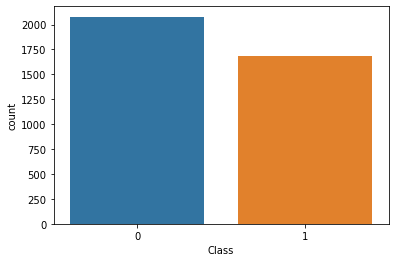

In [6]:
#plot the value count
sns.countplot(brain_df['Class'])

## Get our data ready!!

In [7]:
path_list = []
base_path = '../input/brain-tumor/Brain Tumor/Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append( os.path.join(base_path,entry))

In [8]:
#create path dictonary and then map itto brain_df['pathes']
pathes_dict={os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
brain_df['pathes'] = brain_df['Image'].map(pathes_dict.get)

In [9]:
brain_df.head()

,Image,Class,pathes
0,Image1,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
1,Image2,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
2,Image3,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
3,Image4,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
4,Image5,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...


## plotting some samples from the dataset

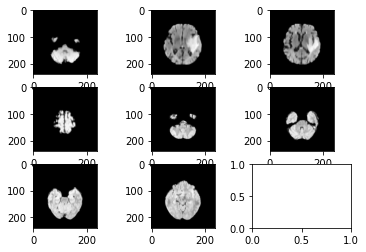

In [10]:

for x in range (0 ,9):
    img = imread(brain_df['pathes'][x])
    plt.imshow(img)
    plt.subplot(3,3,x+1)

In [11]:
from PIL.Image import open
brain_df['pixels']=brain_df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))


In [12]:
brain_df.head()

,Image,Class,pathes,pixels
0,Image1,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## preprocessing our dataset before using MobileNet

In [13]:
image_list = []
for i in range(0,len(brain_df)):
    # load image
    brain_img = brain_df['pixels'][i].astype(np.float32)
    img_array = image.img_to_array(brain_img)
     # append to list of all images
    image_list.append(keras.applications.mobilenet_v2.preprocess_input(img_array))
    
# convert image list to single array
# Our feature
X = np.array(image_list)

# print shape of X
print(X.shape)

(3762, 224, 224, 3)


In [14]:
# get the class label as np.array
y = np.array(brain_df.Class)

In [15]:
y

array([0, 0, 1, ..., 0, 0, 0])

## Splitting the dataset to training set(80%) and testing set (20%)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y
                                                 ,test_size=0.2
                                                ,random_state=0)


print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : 3009
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: 753


## Build model(MobileNet)

In [17]:
num_classes = 1
model = Sequential()
model.add(MobileNetV2(input_shape=(224, 224, 3),weights="imagenet"
                             ,include_top=False))
model.add(keras.layers.GlobalAveragePooling2D())
model.add( Dense(num_classes, activation='sigmoid',name='preds'))
model.layers[0].trainable= False
# show model summary
model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)


# mock-train the model 
model.fit(
    X_train[:,:,:,:],
    y_train[:],
    epochs=110,
    verbose=1,
    validation_data=(X_test[:,:,:,:], y_test[:])
)
model.save("model_brain.h5")
print("Saved model to disk")

Epoch 1/110
95/95 [==============================] - 5s 53ms/step - loss: 0.6325 - accuracy: 0.6361 - val_loss: 0.5843 - val_accuracy: 0.6773
Epoch 2/110
95/95 [==============================] - 3s 36ms/step - loss: 0.5253 - accuracy: 0.7620 - val_loss: 0.4979 - val_accuracy: 0.7742
Epoch 3/110
95/95 [==============================] - 3s 36ms/step - loss: 0.4740 - accuracy: 0.7959 - val_loss: 0.4671 - val_accuracy: 0.8021
Epoch 4/110
95/95 [==============================] - 3s 36ms/step - loss: 0.4430 - accuracy: 0.8112 - val_loss: 0.4392 - val_accuracy: 0.8114
Epoch 5/110
95/95 [==============================] - 3s 36ms/step - loss: 0.4214 - accuracy: 0.8269 - val_loss: 0.4229 - val_accuracy: 0.8154
Epoch 6/110
95/95 [==============================] - 3s 36ms/step - loss: 0.4043 - accuracy: 0.8308 - val_loss: 0.4166 - val_accuracy: 0.8074
Epoch 7/110
95/95 [==============================] - 3s 36ms/step - loss: 0.3904 - accuracy: 0.8385 - val_loss: 0.4012 - val_accuracy: 0.8327
Epoch 

In [19]:
pretrained_cnn = keras.models.load_model('./model_brain.h5')

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(X_test,y_test)
# print loss score
print('Eval loss:',eval_score[0])
# print accuracy score
print('Eval accuracy:',eval_score[1] )

24/24 [==============================] - 1s 27ms/step - loss: 0.2664 - accuracy: 0.8938
Eval loss: 0.2664335370063782
Eval accuracy: 0.8937582969665527


In [20]:
y_pred = pretrained_cnn.predict_classes(X_test)

In [21]:
from sklearn.metrics import confusion_matrix , classification_report
target_classes = ['No Tumor','Tumor']
classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{'No Tumor': {'precision': 0.8846153846153846,
  'recall': 0.92,
  'f1-score': 0.9019607843137256,
  'support': 400},
 'Tumor': {'precision': 0.9050445103857567,
  'recall': 0.8640226628895185,
  'f1-score': 0.8840579710144929,
  'support': 353},
 'accuracy': 0.8937583001328021,
 'macro avg': {'precision': 0.8948299475005707,
  'recall': 0.8920113314447593,
  'f1-score': 0.8930093776641093,
  'support': 753},
 'weighted avg': {'precision': 0.8941923851425311,
  'recall': 0.8937583001328021,
  'f1-score': 0.8935680976010706,
  'support': 753}}

### There is only 81 images out of 753 testing images are misclassified 

In [22]:
confusion_matrix(y_test , y_pred ) 

array([[368,  32],
       [ 48, 305]])